In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import multiprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from statistics import pstdev

# PREDICTING SUCCESS OF NORTH AMERICAN VIDEO GAME SALES

## Table Of Contents
1. [Understanding and Preparing](#preprocess)
2. [Visualizing the Data](#visualize)
3. [Setting up Naive Bayes](#settingup)
4. [Training our NaiveBayes Model](#trainingModel0)
5. [Results and Discussion](#results)

## Understanding and Preparing the Data <a name="preprocess"></a>

First we read the data which is in a csv file into a dataframe,

In [2]:
## base_vgs_df ==== Base Video Game Sales DataFrame

base_vgs_df = pd.read_csv('../VideoGameSalesProject2021/Video_Games_Sales_as_at_22_Dec_2016.csv')

base_vgs_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#total number of video games in base_vgs_df

base_vgs_df['Platform'].size

16719

Here we can see what our data looks like. Each individual row represents one video games and its attributes include,

- Name                
- Platform           
- Year_of_Release    
- Genre              
- Publisher       
- NA_Sales              
- EU_Sales              
- JP_Sales         
- Other_Sales      
- Global_Sales        
- Critic_Score   
- Critic_Count   
- User_Score 
- User_Count   
- Developer       
- Rating  

NOTE: We briefly searched and cleaned the categorical attributes in the csv file before reading it into a dataframe, for example we replaced values such as 'Unknown' and 'None' as these were supposed to be NA data points.

Then we check for the rest of the missing or incorrect values and get an idea of the contents in each of the columns.

In [4]:
## checking for missing values by adding up all missing values in each column
base_vgs_df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher           255
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

We see that the columns, Critic_Score, Critic_Count, User_Score, and User_Count are all missing for more than 50% of the games and Developer/Rating are also missing a large number of values. There are also more problems with the numerical attributes then just missing values so we took a look at each columns' distribution, minimums, and maximums.

In [5]:
base_vgs_df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,7.125046,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,1.500006,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


Upon inspection we see that the max value in Year_of_Release is 2020, which must be pre-release or something of that nature. This data set was recorded and published in 2016 so are going to only look at video games made in 2016 or earlier.

We also see that there is a large difference between the max of columns NA_Sales, EU_Sales, JP_Sales, Other_Sales and Global_Sales and the rest of the data points in each of these columns suggestin that is may have an exponential distribution.

Another important thing to note is that these numbers appear to be in millions according to source of this data set. 

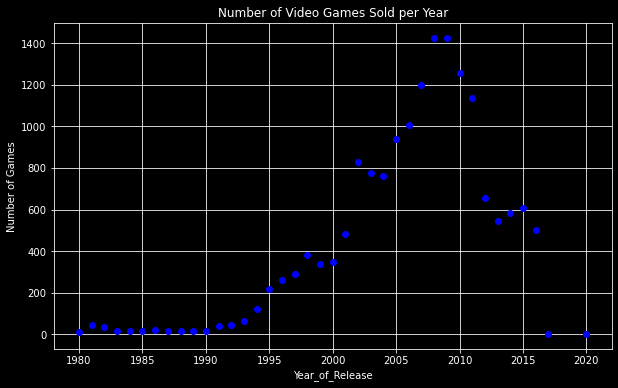

In [6]:
##graph the number of games released per year

#create a dummy column to help count total number of video games
base_vgs_df['dummy'] = np.ones(base_vgs_df['Platform'].size)

num_games_per_year = base_vgs_df.groupby("Year_of_Release")['dummy'].count()

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))

plt.plot(num_games_per_year, 'bo')
plt.ylabel('Number of Games')
plt.xlabel('Year_of_Release')
plt.title('Number of Video Games Sold per Year')
plt.grid()

We can see that there were only a couple games with a date of release after 2016 so we will drop these values. 

An important thing to note when considering these video game sales is what consoles were being released at the time. We agreed that if we want to find the most accurate predictors of NA sales in the future we should look data is the immediate past as the video gaming seen has changed drastically from when it started. But where do we start? We see a peak near 2008, this was when the Wii, Xbox 360, and Playstation 3 came out. These consoles are slowly going out of fashion so let's drop games released after these consoles came out. In 2009 we start to see a decline in console games which is certaintly a trend that is most important for us to capture.

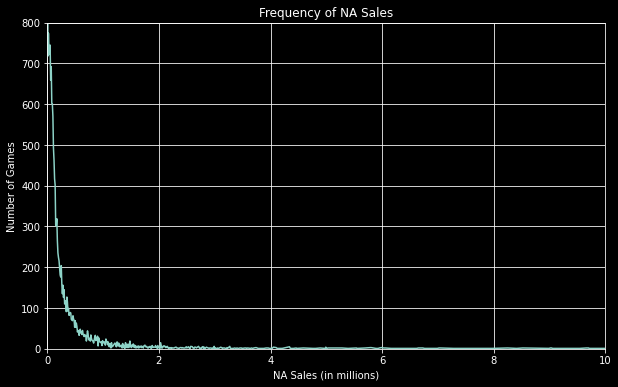

In [7]:
#create a dataframe of video games released between the years 2009-2016 (inclusive) then look at the frequency of NA sales

#drop rows released before 2009 and after 2016 and return a dataframe
post_2009_vgs_df = pd.concat([base_vgs_df.loc[base_vgs_df['Year_of_Release'] >= 2009,:],base_vgs_df.loc[base_vgs_df['Year_of_Release'] < 2017,:]])

freq_NA_sales = post_2009_vgs_df.groupby("NA_Sales")['dummy'].count()

plt.figure(figsize=(10, 6))

plt.plot(freq_NA_sales)
plt.ylabel('Number of Games')
plt.xlabel('NA Sales (in millions)')
plt.title('Frequency of NA Sales')
plt.xlim(0, 10)
plt.ylim(0,800)
plt.grid()

Here we see the frequency of NA Sales is super high close to 0 and is very small anywhere beyond 2. We can see that this is an exponential distribution so a log transform could be useful if trying to normalize this data. Assuming that the games that sold zero copies in North America are the ones that are 0.00, we can drop these values.


## Visualization <a name="visualize"></a>

In order to visualize the data we made all the changes listed below. Here is what they are,

- Drop columns that are missing over 50% of the values i.e. Critic_score, critic_count, User_Score, User_Count, and Rating

- Drop rows with missing values in any column that is not one of the ones listed above

- Drop all rows with the Year_of_Release below or above the range 2009-2016

- Drop rows where NA_Sales == 0.00

- (Optional) Normalize NA_Sales as it shows an exponential distribution

In [8]:
# get rid of columns missing over 50% of values and get rid of all remaining rows contained a null value
std_vgs_df = base_vgs_df.dropna(axis=1, thresh = 9000).dropna().reset_index(drop = True)

# drop video games release before or after 2009-1016
std_vgs_df = std_vgs_df[std_vgs_df.Year_of_Release > 2008.0]
std_vgs_df = std_vgs_df[std_vgs_df.Year_of_Release < 2017.0]

# drop video games that did not sell in North America (NA_Sales == 0.00)
std_vgs_df = std_vgs_df[std_vgs_df.NA_Sales != 0.00].reset_index(drop = True)

# add a column that is the log transform of the NA_Sales column
std_vgs_df['Normalized_NA_Sales'] = np.log(std_vgs_df['NA_Sales'])

std_vgs_df['dummy'].size

3616

In [9]:
std_vgs_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Rating,dummy,Normalized_NA_Sales
0,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo,E,1.0,2.747912
1,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,Nintendo,E,1.0,2.670002
2,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,Good Science Studio,E,1.0,2.708050
3,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,Nintendo,E,1.0,2.198335
4,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,Rockstar North,M,1.0,1.948763


With our data now properly cleaned we are left with 3616 video games to use to train our model. Unfortunately this is ~1/5 of the original sample size but the adjustments we made were necessary. 

We decided that we wanted to use a Gaussian Naive Bayes Model to help us predict whether or not a video game will be successful in North America. To define success, we create a column and assign either 0 or 1 to each game. Video games that had sales worse than 50% of all video will be assigned 0 while video games that had sales in the top 50% of video games will be assigned a 1. This is the column we will use to test a video games success. 

The attributes that we decide to use as predicters of NA_Sales success are,

- Platform
- Genre
- Publisher
- Developer

We will create visualiztions for each of these attributes in order to better understand our data.

In [10]:
# find the 50th percentile marker so we can choose games that are above aka 'Sold Well' and games that below aka 'Sold Poorly'
midpoint_sales = std_vgs_df['NA_Sales'].describe()['50%'] ## this midpoint is the .5 quartile marker, so better than this is better than half of all the games produced

std_vgs_df['good_or_bad'] = np.zeros(std_vgs_df['Platform'].size, dtype = 'int32')
std_vgs_df.loc[std_vgs_df['NA_Sales'] > midpoint_sales, 'good_or_bad'] = 1

In [11]:
std_vgs_df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Rating,dummy,Normalized_NA_Sales,good_or_bad
0,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,Nintendo,E,1.0,2.747912,1
1,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,Nintendo,E,1.0,2.670002,1
2,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,15.00,4.89,0.24,1.69,21.81,Good Science Studio,E,1.0,2.708050,1
3,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.01,8.49,2.53,1.77,21.79,Nintendo,E,1.0,2.198335,1
4,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.02,9.09,0.98,3.96,21.04,Rockstar North,M,1.0,1.948763,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,The Ultimate Battle of the Sexes,Wii,2010.0,Misc,DTP Entertainment,0.01,0.00,0.00,0.00,0.01,Neopica,T,1.0,-4.605170,0
3612,Metal Gear Solid V: The Definitive Experience,XOne,2016.0,Action,Konami Digital Entertainment,0.01,0.00,0.00,0.00,0.01,Kojima Productions,M,1.0,-4.605170,0
3613,End of Nations,PC,2012.0,Strategy,Trion Worlds,0.01,0.00,0.00,0.00,0.01,Petroglyph,T,1.0,-4.605170,0
3614,Outdoors Unleashed: Africa 3D,3DS,2011.0,Sports,Mastiff,0.01,0.00,0.00,0.00,0.01,Mastiff,T,1.0,-4.605170,0


In [12]:
std_vgs_df['Platform'].unique()

array(['Wii', 'X360', 'PS3', '3DS', 'PS4', 'PC', 'WiiU', 'DS', 'XOne',
       'PSP', 'PS2', 'PSV'], dtype=object)

We decided that in order to visualize how platforms performed, we could group different platforms together by their creators,

In [13]:
## create general platform column

std_vgs_df['General_Platform']= base_vgs_df['Platform']

std_vgs_df.loc[std_vgs_df['Platform'] == 'PS3', 'General_Platform'] =  'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS', 'General_Platform'] = 'Sony_Playstation' 
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS2', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PS4', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PSP', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PSV', 'General_Platform'] = 'Sony_Playstation'
std_vgs_df.loc[std_vgs_df['Platform'] == 'Wii', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'DS', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'GBA', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == '3DS', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'WiiU', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'NES', 'General_Platform'] = 'Nintendo'
std_vgs_df.loc[std_vgs_df['Platform'] == 'X360', 'General_Platform'] = 'Microsoft_Xbox'
std_vgs_df.loc[std_vgs_df['Platform'] == 'XOne', 'General_Platform'] = 'Microsoft_Xbox'
std_vgs_df.loc[std_vgs_df['Platform'] == 'PC', 'General_Platform'] = 'PC'

Now that we have our General_Platform column, we use it to make three unique graphs,

- Number of Games Produced by General Platform Per Year
- Sum of North American Sales By General Platforms Per Year
- Average Sales per Game by General Platform Per Year

Text(0.5, 0, 'Year of Release')

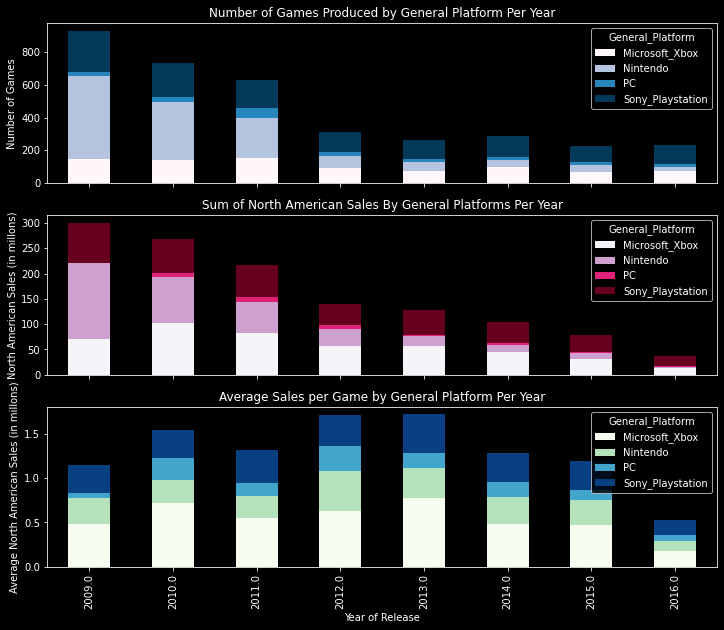

In [14]:
#create df that is grouped by Year_of_Release and General_Platform then sum NA_Sales and dummy.
platform_df = std_vgs_df.groupby(['Year_of_Release', 'General_Platform'])[['dummy','NA_Sales','good_or_bad']].sum()
platform_df['avg_sales'] = platform_df['NA_Sales'].div(platform_df['dummy'])



fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

#Number of Games Produced by General Platform Per Year
platform_df['dummy'].unstack().plot(ax= axes[0],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'PuBu')

#Sum of North American Sales By General Platforms Per Year
platform_df['NA_Sales'].unstack().plot(ax= axes[1],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'PuRd')

#Average Sales per Game by General Platform Per Year
platform_df['avg_sales'].unstack().plot(ax= axes[2],kind='bar',stacked=True,  
                           grid=False,  figsize=(12,10), cmap = 'GnBu')

axes[0].set_title('Number of Games Produced by General Platform Per Year')
axes[0].set_ylabel('Number of Games')
axes[0].set_xlabel('Year of Release')
axes[1].set_title('Sum of North American Sales By General Platforms Per Year')
axes[1].set_ylabel('North American Sales (in millons)')
axes[1].set_xlabel('Year of Release')
axes[2].set_title('Average Sales per Game by General Platform Per Year')
axes[2].set_ylabel('Average North American Sales (in millons)')
axes[2].set_xlabel('Year of Release')

We can see that the total number of games produced is proportional to the sum of NA_sales per platform. We also see that overall, games released for Microsoft_Xbox generally do the best when it comes to average sales.

We perform a similar analysis for Genre,

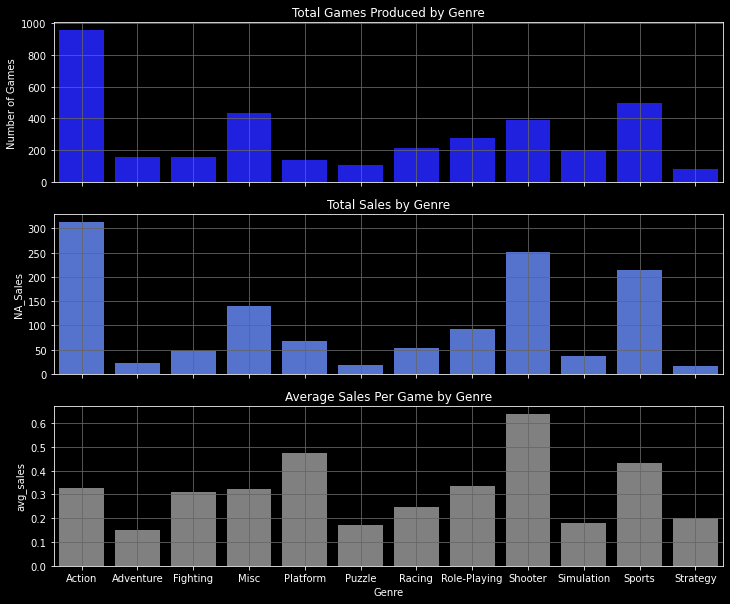

In [15]:
games_by_genre_total = std_vgs_df.groupby(['Genre'])[['dummy','NA_Sales', 'good_or_bad']].sum()
games_by_genre_total['avg_sales'] = games_by_genre_total['NA_Sales'].div(games_by_genre_total['dummy'])

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

sb.barplot(ax = axes[0], x = games_by_genre_total.index.values, y=games_by_genre_total['dummy'], color = 'blue')
sb.barplot(ax = axes[1], x = games_by_genre_total.index.values, y=games_by_genre_total['NA_Sales'], color = 'royalblue')
sb.barplot(ax = axes[2], x = games_by_genre_total.index, y=games_by_genre_total['avg_sales'], color = 'grey')

axes[0].set_title('Total Games Produced by Genre')
axes[1].set_title('Total Sales by Genre')
axes[2].set_title('Average Sales Per Game by Genre')
axes[0].set_ylabel('Number of Games')
axes[0].grid(b = True, color = '#666666')
axes[1].grid(b = True, color = '#666666')
axes[2].grid(b = True, color = '#666666')


We see a proportional relationship between total games by genre and total sales by genre. We see that Shooter, Action, and Sport games are the most popular while Shooter, Platform, and Sports have the highest average sales per game.

We perform a similar analysis of Publishers,

Text(0.5, 1.0, 'Top 20 Highest Average Sales per Game by Publisher')

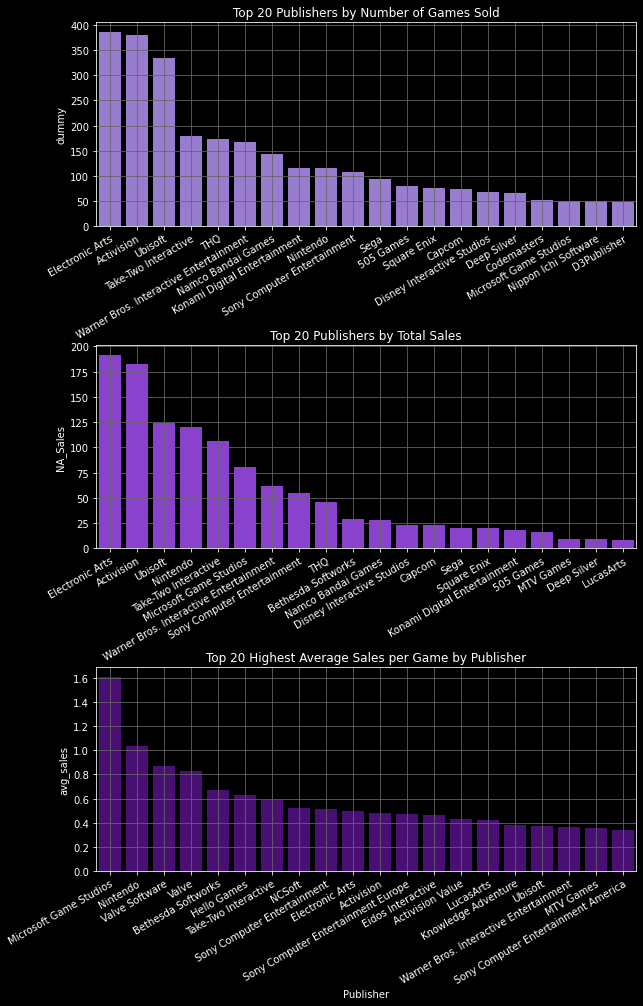

In [16]:
publisher_df = std_vgs_df.groupby(['Publisher'])[['dummy','NA_Sales', 'good_or_bad']].sum()
publisher_df['avg_sales'] = publisher_df['NA_Sales'].div(publisher_df['dummy'])
##top 20 publishers

top_20_totals_pub = publisher_df['dummy'].nlargest(20)
top_20_sales_pub = publisher_df['NA_Sales'].nlargest(20)
top_20_avg_pub = publisher_df['avg_sales'].nlargest(20)

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

sb.barplot(ax = axes[0],x = top_20_totals_pub.index.values, y= top_20_totals_pub, color = 'mediumpurple')
sb.barplot(ax = axes[1],x = top_20_sales_pub.index.values, y= top_20_sales_pub, color = 'blueviolet')
sb.barplot(ax = axes[2],x = top_20_avg_pub.index, y= top_20_avg_pub, color = 'indigo')

fig.tight_layout(pad=10.0)

plt.setp(axes[0].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
plt.setp(axes[1].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
plt.setp(axes[2].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
axes[0].grid(b = True, color = '#666666')
axes[1].grid(b = True, color = '#666666')
axes[2].grid(b = True, color = '#666666')
axes[0].set_title('Top 20 Publishers by Number of Games Sold')
axes[1].set_title('Top 20 Publishers by Total Sales')
axes[2].set_title('Top 20 Highest Average Sales per Game by Publisher')


We can see that again total games sold and total sales are closely related. The top publisher by average sales per video game sales is Microsoft Game studio by far, with Nintendo and Valve Software trailing behind.

And finally we look at our Developer attribute,

Text(0.5, 1.0, 'Top 20 Highest Average Sales per Game by Developer')

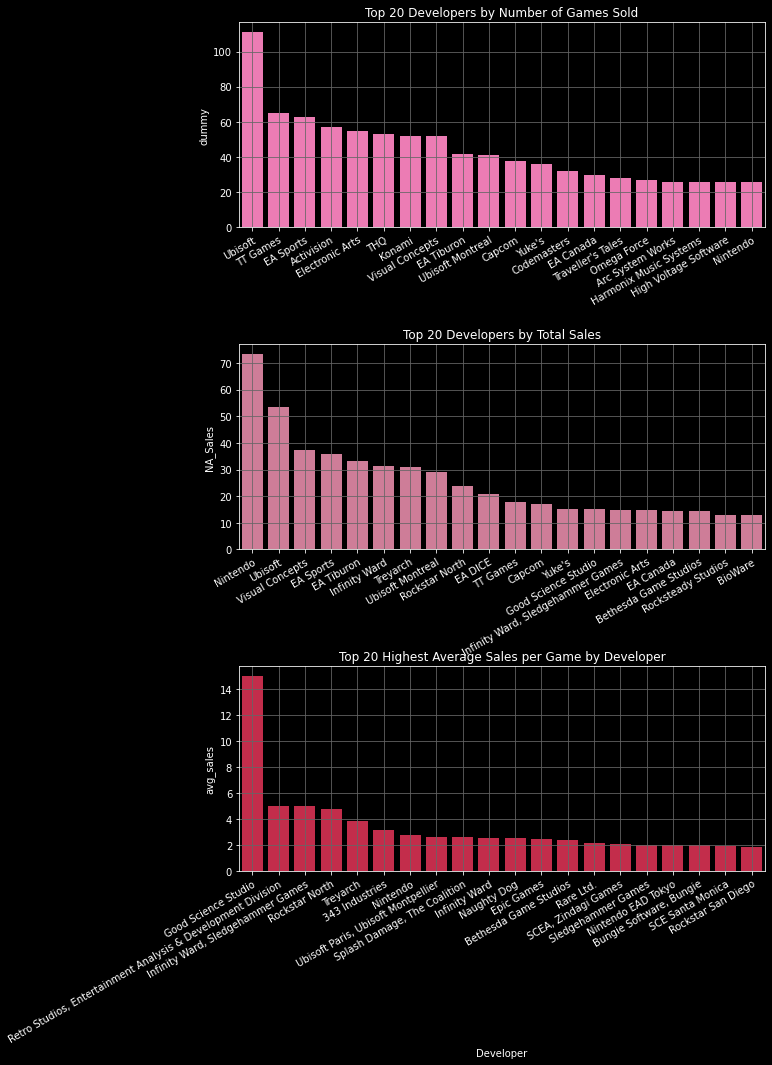

In [17]:
developer_df = std_vgs_df.groupby(['Developer'])[['dummy','NA_Sales', 'good_or_bad']].sum()
developer_df['avg_sales'] = developer_df['NA_Sales'].div(developer_df['dummy'])
##top 20 publishers

top_20_totals_dev = developer_df['dummy'].nlargest(20)
top_20_sales_dev = developer_df['NA_Sales'].nlargest(20)
top_20_avg_dev = developer_df['avg_sales'].nlargest(20)

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

sb.barplot(ax = axes[0],x = top_20_totals_dev.index.values, y= top_20_totals_dev, color = 'hotpink')
sb.barplot(ax = axes[1],x = top_20_sales_dev.index.values, y= top_20_sales_dev, color = 'palevioletred')
sb.barplot(ax = axes[2],x = top_20_avg_dev.index, y= top_20_avg_dev, color = 'crimson')

fig.tight_layout(pad=10.0)

plt.setp(axes[0].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
plt.setp(axes[1].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
plt.setp(axes[2].get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    
axes[0].grid(b = True, color = '#666666')
axes[1].grid(b = True, color = '#666666')
axes[2].grid(b = True, color = '#666666')
axes[0].set_title('Top 20 Developers by Number of Games Sold')
axes[1].set_title('Top 20 Developers by Total Sales')
axes[2].set_title('Top 20 Highest Average Sales per Game by Developer')

Similar to the past visualizations we can see that the total number of games and sales are closely related. However we start to see smaller developers leading in the highest average sales per video game diagram with Good Science studio well ahead of everyone else. Its important to note that developers such as Good Science Studio have created very few games, in this case 1 game, and its done very well. But regardless of how well its average sales are, developers like Nintendo who create many games will have more of an influence on the gamers of the world.

# Naive Bayes Set-Up <a name="settingup"></a>

For a Naive Bayes Model, the probabilities for each of our attributes 'Selling Well' and 'Selling Poorly' will be useful to know or have an idea of. We want to know which attributes will have the most effect on our model. To see these probabilites, we put them into a dataframe along with some additional information.

In [18]:
platform_df['P Sold Well'] = platform_df['good_or_bad'].div(platform_df['dummy'])
platform_df['P Sold Poorly'] = 1 - platform_df['P Sold Well']
platform_df['Type'] = 'Platform'

games_by_genre_total['P Sold Well'] = games_by_genre_total['good_or_bad'].div(games_by_genre_total['dummy'])
games_by_genre_total['P Sold Poorly'] = 1 - games_by_genre_total['P Sold Well']
games_by_genre_total['Type'] = 'Genre'

publisher_df['P Sold Well'] = publisher_df['good_or_bad'].div(publisher_df['dummy'])
publisher_df['P Sold Poorly'] = 1 - publisher_df['P Sold Well']
publisher_df['Type'] = 'Publisher'

developer_df['P Sold Well'] = developer_df['good_or_bad'].div(developer_df['dummy'])
developer_df['P Sold Poorly'] = 1 - developer_df['P Sold Well']
developer_df['Type'] = 'Developer'

naive_bayes_probabilities = pd.concat([platform_df,games_by_genre_total,publisher_df, developer_df])

top_5 = pd.concat([platform_df.nlargest(5,columns = 'P Sold Well'),games_by_genre_total.nlargest(5,columns = 'P Sold Well'),publisher_df.nlargest(5,columns = 'P Sold Well'),developer_df.nlargest(5,columns = 'P Sold Well')])
bot_5 =pd.concat([platform_df.nsmallest(5,columns = 'P Sold Well'),games_by_genre_total.nsmallest(5,columns = 'P Sold Well'),publisher_df.nsmallest(5,columns = 'P Sold Well'),developer_df.nsmallest(5,columns = 'P Sold Well')])

naive_bayes_probabilities.loc[naive_bayes_probabilities['dummy'] > 10, :].nlargest(20, columns = 'P Sold Well')

,dummy,NA_Sales,good_or_bad,avg_sales,P Sold Well,P Sold Poorly,Type
Nintendo,26.0,73.26,25,2.817692,0.961538,0.038462,Developer
Vicarious Visions,18.0,6.56,17,0.364444,0.944444,0.055556,Developer
EA Canada,30.0,14.45,28,0.481667,0.933333,0.066667,Developer
EA Tiburon,42.0,33.02,39,0.786190,0.928571,0.071429,Developer
BioWare,19.0,12.81,17,0.674211,0.894737,0.105263,Developer
Yuke's,36.0,15.01,32,0.416944,0.888889,0.111111,Developer
Nintendo,116.0,119.92,100,1.033793,0.862069,0.137931,Publisher
Blizzard Entertainment,14.0,12.67,12,0.905000,0.857143,0.142857,Developer
LucasArts,20.0,8.50,17,0.425000,0.850000,0.150000,Publisher
Microsoft Game Studios,50.0,80.34,42,1.606800,0.840000,0.160000,Publisher


In [19]:
naive_bayes_probabilities.loc[naive_bayes_probabilities['dummy'] > 10, :].nlargest(20, columns = 'P Sold Poorly')

,dummy,NA_Sales,good_or_bad,avg_sales,P Sold Well,P Sold Poorly,Type
Playlogic Game Factory,11.0,0.67,0,0.060909,0.000000,1.000000,Publisher
Destineer,14.0,0.93,0,0.066429,0.000000,1.000000,Developer
"(2009.0, PC)",24.0,1.35,1,0.056250,0.041667,0.958333,Platform
DTP Entertainment,14.0,0.91,1,0.065000,0.071429,0.928571,Publisher
Nippon Ichi Software,50.0,3.82,4,0.076400,0.080000,0.920000,Publisher
Kalypso Media,11.0,0.70,1,0.063636,0.090909,0.909091,Publisher
Destineer,21.0,2.04,2,0.097143,0.095238,0.904762,Publisher
"(2016.0, PC)",19.0,1.28,2,0.067368,0.105263,0.894737,Platform
Focus Home Interactive,19.0,1.39,2,0.073158,0.105263,0.894737,Publisher
City Interactive,15.0,1.63,2,0.108667,0.133333,0.866667,Publisher


Here we see the specific attribute values that are linked to video games 'Selling Well' vs 'Selling Poorly'. The rows in this dataframe represent values within the four columns, 'Genre', 'General_Platform', 'Developer', and 'Publisher' that we will use to train our Naive Bayes Model. We can see that the first table is listed in order starting with the highest probability of 'Selling Well', i.e. 'P Sold Well'. The second table is in the opposite order, or by 'P Sold Poorly'. The top predictors appear to be primarily Developers and Publishers with Nintendo at the top. We can get some idea about the best and worst predictors of a video game selling well.

Now we found the base probability of a video game selling well so we have something to compare our model to. This is simply done by taking the number of video games that sold well and dividing it by the total number of video games.

In [20]:
#calculate the probability of the sales of a game being above the midpoint before modeling
base_probability = std_vgs_df.loc[std_vgs_df['NA_Sales']> midpoint_sales, 'Normalized_NA_Sales'].size / std_vgs_df['Normalized_NA_Sales'].size

Since fitting our Naive Bayes Model won't work with categorical data, we found a way to enumerate them. We created dummy columns for each of our attribute columns. This caused our dataframe to get a lot bigger but the values added were either 0s or 1s. Essentially we made a column for every value in 'Genre', 'General_Platform', 'Developer', and 'Publisher'. This will make it possible to fit our model.

In [21]:
#processing are categorical data and making dummy columns in order to train our model        
tempor1 = pd.get_dummies(std_vgs_df.Genre, prefix = 'Genre')
tempor2 = pd.get_dummies(std_vgs_df.Publisher, prefix = 'Publisher')
tempor3 = pd.get_dummies(std_vgs_df.Developer, prefix = 'Developer')
#tempor4 = pd.get_dummies(std_vgs_df.Platform, prefix = 'Platform')
tempor4 = pd.get_dummies(std_vgs_df.Platform, prefix = 'General_Platform')

std_vgs_df = pd.concat([std_vgs_df, tempor1, tempor2, tempor3, tempor4], axis = 1)

final_data = std_vgs_df.drop(['good_or_bad','Name', 'Platform', 'Year_of_Release','Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer', 'Rating', 'dummy', 'General_Platform', 'Normalized_NA_Sales'], axis=1)

#our full dataset
X = final_data.reset_index(drop = True)
y = np.array(std_vgs_df.good_or_bad.values)

## Gaussian Naive Bayes Cross Validation with MapReduce based algorithm <a name="trainingModel0"></a>

In [22]:
## Here is where we see how accurate our Naive Bayes Model is for predicting whether or not the sales of a game will be in top 50th percentile
def get_scores(data_lis, return_lis):
    # acts as a MAPPER as our Naive Bayes model is training itself from two inputs (dataframe and array) and returning a list of predictions
    y_pred = gnb.fit(data_lis[0], data_lis[2]).predict(data_lis[1])
    # acts as REDUCER because it is taking the list of predictions as input and outputting a float value that is the accuracy score
    return_lis.append(accuracy_score(data_lis[3], y_pred))

# number of folds for our cross validation
kfolds = 6

#split the data into training and test set while shuffling the training set in kfolds, returns a bunch of 1D arrays of indexes
shuffle = StratifiedShuffleSplit(n_splits = kfolds, test_size = 0.3, random_state = 59)
shuffled_data = shuffle.split(X, y)

#initialize our Gaussian Naive Bayes Model
gnb = GaussianNB()

#using the lists of indexes to prepare subsets of train and test data for parallel computing
#output is a list of lists that each contain 4 pieces of data for each kfold: X_train, X_test, y_train, y_test
list_of_splits = []
for train_index, test_index in shuffled_data:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    full_set = [X_train, X_test, y_train, y_test]
    list_of_splits.append(full_set)
    
#run the get_scores method in parallel for each of the kfolds and combine the scores in a list    
processes = []
if __name__ == '__main__':
    final_list= []
    manager = multiprocessing.Manager()
    final_list = manager.list()

    for i in range(kfolds):
        p = multiprocessing.Process(target = get_scores(list_of_splits[i],final_list))
        p.start()
        processes.append(p)
    for pro in processes:
        pro.join()

#accuracy scores from all folds
list_of_scores = list(final_list)

print('The probability of a game\'s sales to be in the top 50th percentile before modeling is : %f'
      % (base_probability))
print('These are our results from cross validation : ', list_of_scores)
print('The average score for our models in our cross validation of %d folds : %f with a standard deviation of %f'
      % (kfolds, sum(list_of_scores)/len(list_of_scores), pstdev(list_of_scores)))

The probability of a game's sales to be in the top 50th percentile before modeling is : 0.477046
These are our results from cross validation :  [0.6064516129032258, 0.5935483870967742, 0.6101382488479262, 0.6110599078341014, 0.5852534562211982, 0.5963133640552996]
The average score for our models in our cross validation of 6 folds : 0.600461 with a standard deviation of 0.009470


## Results and Discussion <a name="results"></a>

The results of our Gaussian Naive Bayes Model were on average 60.00% accurate with a standard deviation of 0.01. This is ~13% better than if we had guessed the success of a video game's sales without a model. There is plenty room for improvement with this prediction and many additional methods and models we could apply to this data set. 

From our probabilites dataframe we can see that the top and bottom five performers of each attribute are:

In [23]:
top_5

,dummy,NA_Sales,good_or_bad,avg_sales,P Sold Well,P Sold Poorly,Type
"(2013.0, Microsoft_Xbox)",73.0,56.75,55,0.777397,0.753425,0.246575,Platform
"(2012.0, Microsoft_Xbox)",90.0,56.71,61,0.630111,0.677778,0.322222,Platform
"(2015.0, Microsoft_Xbox)",68.0,31.96,44,0.470000,0.647059,0.352941,Platform
"(2014.0, Microsoft_Xbox)",95.0,45.80,60,0.482105,0.631579,0.368421,Platform
"(2010.0, Microsoft_Xbox)",143.0,103.31,89,0.722448,0.622378,0.377622,Platform
Shooter,392.0,250.60,230,0.639286,0.586735,0.413265,Genre
Fighting,156.0,48.06,91,0.308077,0.583333,0.416667,Genre
Sports,499.0,214.58,282,0.430020,0.565130,0.434870,Genre
Role-Playing,277.0,92.94,136,0.335523,0.490975,0.509025,Genre
Action,957.0,313.67,467,0.327764,0.487983,0.512017,Genre


In [24]:
bot_5

,dummy,NA_Sales,good_or_bad,avg_sales,P Sold Well,P Sold Poorly,Type
"(2009.0, PC)",24.0,1.35,1,0.056250,0.041667,0.958333,Platform
"(2016.0, PC)",19.0,1.28,2,0.067368,0.105263,0.894737,Platform
"(2015.0, PC)",19.0,2.21,4,0.116316,0.210526,0.789474,Platform
"(2016.0, Nintendo)",22.0,2.57,5,0.116818,0.227273,0.772727,Platform
"(2016.0, Sony_Playstation)",113.0,19.00,27,0.168142,0.238938,0.761062,Platform
Puzzle,108.0,18.42,29,0.170556,0.268519,0.731481,Genre
Adventure,158.0,23.52,46,0.148861,0.291139,0.708861,Genre
Strategy,80.0,16.21,27,0.202625,0.337500,0.662500,Genre
Simulation,201.0,36.49,70,0.181542,0.348259,0.651741,Genre
Racing,214.0,52.44,80,0.245047,0.373832,0.626168,Genre


Regarding the data, there are multiple avenues left to explore. One problem with our model was that developers and publishers that produced a very small amount of video games which sold well had probabilites that had the same weight in training our model as publishers/developers with large amounnts of games produced that sold well. It seems to me that the there needs to be a way to deal with this because for example games produced by Nintendo, which is one of the leading publishers/developers of the video game world had technically a lower probability of selling well than Good Science Studio, which only made a single game that sold well. 

Another avenue to pursue is looking at what is happening year to year for Developers, Publishers and Genre. We partially do this for General Platforms but only use it as a visualization. It is likely that their are yearly trends that could lead to more accurate predictions about whether games will sell well. Unfortunately in the end we did not have enough data to effectively do this but if we had we could of dove deeper into yearly trends.